# Assignment 8: AutoEncoders

In [101]:
# enter your name and UFL email address
name = 'Kamal Sai Raj K'
email = 'k.kuncha@ufl.edu'

In [102]:
if name == 'enter your name' or email == 'enter your email':
    assert False, 'Enter your name & email first!'
else:
    print('Assignment 8 -- name: {}, email: {}\n'.format(name, email))
    
    # Load packages we need
    import sys
    import os
    import time

    import numpy as np
    import sklearn
    
    # we'll use tensorflow and keras for neural networks
    import tensorflow as tf
    import tensorflow.keras as keras
    
    # import layers we may use
    from tensorflow.keras.layers import Input, Flatten, Reshape, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout

    # import callbacks we may use
    from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
    
    # Load the TensorBoard notebook extension
    #%load_ext tensorboard

    from matplotlib import pyplot as plt
    plt.rcParams.update({'font.size': 16})

    # Let's check our software versions
    print('### Python version: ' + __import__('sys').version)
    print('### NumPy version: ' + np.__version__)
    print('### Scikit-learn version: ' + sklearn.__version__)
    print('### Tensorflow version: ' + tf.__version__)
    print('### TF Keras version: ' + keras.__version__)
    print('------------')


    # load our packages / code
    sys.path.insert(1, '../common/')
    import utils
    import plots
    import nets

Assignment 8 -- name: Kamal Sai Raj K, email: k.kuncha@ufl.edu

### Python version: 3.6.5 (v3.6.5:f59c0932b4, Mar 28 2018, 17:00:18) [MSC v.1900 64 bit (AMD64)]
### NumPy version: 1.19.5
### Scikit-learn version: 0.24.0
### Tensorflow version: 2.4.0
### TF Keras version: 2.4.0
------------


In [103]:
# global parameters to control behavior of the pre-processing, ML, analysis, etc.
seed = 42

# deterministic seed for reproducibility
np.random.seed(seed)
tf.random.set_seed(seed)

prop_vec = [24, 2, 2]

## Once again we will use the MNIST data. Let's load it.

In [104]:
# grab the data
train_x, train_y, test_x, test_y, val_x, val_y, all_x, all_y = utils.load_preprocess_mnist_data(onehot=False, flatten=False, prop_vec=prop_vec, seed=seed)

# sanity check shapes
train_x.shape, train_y.shape, test_x.shape, test_y.shape, val_x.shape, val_y.shape

((60000, 28, 28), (60000,), (5000, 28, 28), (5000,), (5000, 28, 28), (5000,))

In [105]:
# rescale so all pixel values are in the [0,1] range 
train_x = train_x / 255.0
test_x = test_x / 255.0
val_x = val_x / 255.0

## [Task 1] (30 points) Build a simple AutoEncoder (AE).

### [Task 1a] (20 points) Complete the implementation of create_simple_ae() according to the architecture and instructions below.

#### Start by creating the encoder ('enc_model'). It should have the following architecture:
- Flatten
- FC with hidden_widths[0] units with activation ReLU
- FC with hidden_widths[1] units with activation ReLU
- FC with latent_width units with activation *sigmoid*

#### Then create the decoder ('dec_model'). It should have the following architecture:
- (Input has shape latent_width)
- FC with hidden_widths[1] units with activation ReLU
- FC with hidden_widths[0] units with activation ReLU
- FC with 784 units with activation *sigmoid*
- Reshape to input_shape

#### Finally connect the two models together into a new model ('ae_model'). Make sure that the model takes the input that the encoder takes and produces the output that the decoder produces.

In [112]:
def create_simple_ae(input_shape=(28, 28), latent_width=100, hidden_widths=[256, 64], verbose=False):
    name = 'AE-simple'
    
    ###* put your code here (~10-20 lines) *###
    
    # encoder
    enc_input = Input(shape=input_shape, name='Encoder-input')
    enc_flatten = Flatten(name='Flatten')(enc_input)
    enc_fc1 = Dense(hidden_widths[0], activation='relu', name='Encoder-FC1')(enc_flatten)
    enc_fc2 = Dense(hidden_widths[1], activation='relu', name='Encoder-FC2')(enc_fc1)
    enc_latent = Dense(latent_width, activation = 'sigmoid')(enc_fc2) 
    enc_model = keras.Model(inputs=[enc_input], outputs=[enc_latent],name='Encoder')
   
    # decoder
    dec_input = Input(shape=[latent_width], name='Decoder-input')
    dec_fc1 = Dense(hidden_widths[1], activation='relu', name='Decoder-FC1')(dec_input)
    dec_fc2 = Dense(hidden_widths[0], activation='relu', name='Decoder-FC2')(dec_fc1)
    dec_output = Dense(784, activation='sigmoid', name='Decoder-output')(dec_fc2)
    dec_reshape = Reshape(input_shape)(dec_output)
    dec_model = keras.Model(inputs=[dec_input], outputs=[dec_reshape], name='Decoder')

    # connect the two
    latent_space_output = enc_model(enc_input)
    rec_output = dec_model(latent_space_output)
    ae_model = keras.Model(inputs=[enc_input], outputs=[rec_output], name=name)

    opt = keras.optimizers.Adam(lr=0.002)
    
    if verbose:
        ae_model.summary()
    
    ae_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['mse'])
    
    return name, ae_model, enc_model, dec_model

### Let's train the model -- you should get a loss lower than 0.1 and MSE lower than 0.01.

In [113]:
# Let's train the model
latent_width = 48
name, ae_model, enc_model, dec_model = create_simple_ae(latent_width=latent_width, verbose=True)
    
max_epochs = 30
batch_size = 256

hist = ae_model.fit(train_x, train_x, epochs=max_epochs, batch_size=batch_size, validation_data=(val_x, val_x))

Model: "AE-simple"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder-input (InputLayer)   [(None, 28, 28)]          0         
_________________________________________________________________
Encoder (Functional)         (None, 48)                220528    
_________________________________________________________________
Decoder (Functional)         (None, 28, 28)            221264    
Total params: 441,792
Trainable params: 441,792
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
235/235 [==============================] - 4s 15ms/step - loss: 0.3116 - mse: 0.0838 - val_loss: 0.2166 - val_mse: 0.0529
Epoch 2/30
235/235 [==============================] - 3s 14ms/step - loss: 0.2035 - mse: 0.0483 - val_loss: 0.1725 - val_mse: 0.0373
Epoch 3/30
235/235 [==============================] - 4s 16ms/step - loss: 0.1663 - mse: 0.0351 - val_loss: 0.1482 

### Let's reason about the architecture of this auto-encoder.

### [Task 1b] (5 points) Explain the choice of loss function: why is 'binary_crossentropy' a suitable loss function? (Hint: consider what the rest of the architecture looks like and what the data looks like.)

In [114]:
###* put your answer here *###
# This is because the sigmoid activation function is used at the output layer that results in either 0 or 1.
#
#

### [Task 1c] (5 points) Is the AE significantly overfitted? Why or why not? (Justify your answer.)

In [115]:
###* put your answer here *###
# No, I dont think that AE is overfitted as the but it works fine as the loss of reconstruction is less both in the cases
#  of training and validation
#

## [Task 2] (20 points) Using the AE.

### [Task 2a] (10 points) Use plot_images() to plot the first 64 data points in val_x. Then reconstruct val_x through the AE. Finally, plot the first 64 data points of the reconstructed data. 

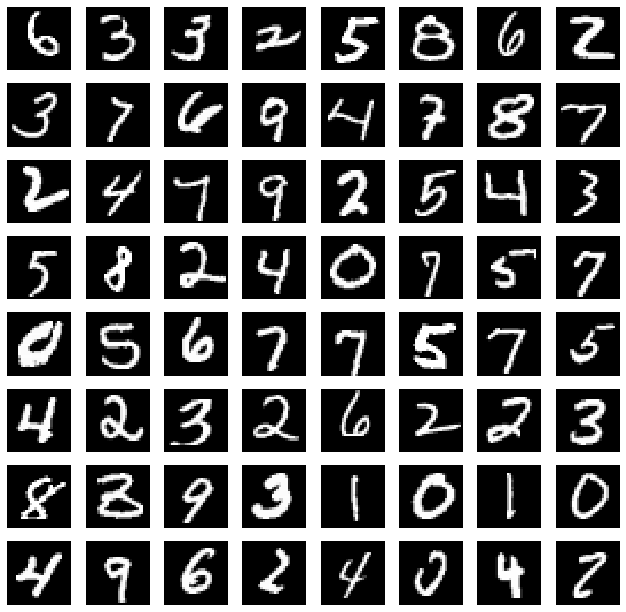

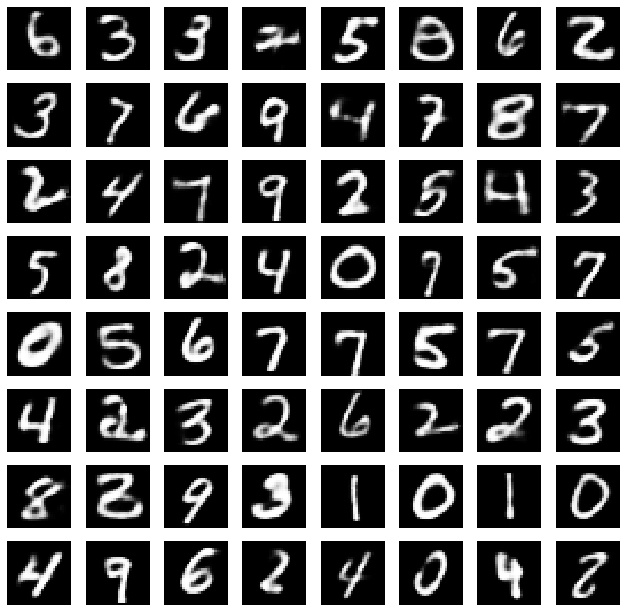

In [116]:
# Plot the first 64 data points of val_x using plots.plot_images()
###* put your code here (~1 line) *###
plots.plot_images(val_x[0:64].reshape(-1, 28, 28), dim_x=28, dim_y=28, fig_size=(11,11))

# Run the first 64 data points in val_x through the auto-encoder to obtain reconstructed_val_x
###* put your code here (~1 line) *###
reconstructed_val_x=ae_model.predict(val_x[0:64])

# Plot the reconstructed data (using plots.plot_images())
###* put your code here (~1 line) *###
plots.plot_images(reconstructed_val_x[0:64].reshape(-1, 28, 28), dim_x=28, dim_y=28, fig_size=(11,11))



### Let's explore the latent space. 

### [Task 2b] (10 points) Compute the average latent space representation of 0s and 8s in the validation data. Call these 'avg_zeros_latent' and 'avg_eights_latent' respectively. 

In [117]:
### Hint: first use the labels to identify which examples in the validation data are 0s and 8s
###       Then compute the latent representation of these examples using the encoder
###       Finally, take the mean of the latent representation for all 0s and then separately for all 8s.
###* put your code here (~5-8 lines) *###
zeros=[]
eights=[]
for i in range(val_y.shape[0]):
    if val_y[i]==8:
        #eights.append(np.transpose(np.array(enc_model(np.expand_dims(val_x[i],0))[0])))
        eights.append(np.transpose(np.array(enc_model(val_x[i].reshape(-1,28,28))[0])))

    elif val_y[i]==0:
        #zeros.append(np.transpose(np.array(enc_model(np.expand_dims(val_x[i],0))[0])))
        zeros.append(np.transpose(np.array(enc_model(val_x[i].reshape(-1,28,28))[0])))


avg_eights_latent=np.mean(eights, axis=0)
avg_zeros_latent=np.mean(zeros, axis=0) 
avg_eights_latent=avg_eights_latent.reshape(48)
avg_zeros_latent=avg_zeros_latent.reshape(48)

In [118]:
assert avg_zeros_latent.shape == (latent_width,) or avg_zeros_latent.shape == (latent_width,1)
assert avg_eights_latent.shape == (latent_width,) or avg_eights_latent.shape == (latent_width,1)

### We will look at the transition between 0 and 8 in the latent space.

In [119]:
def linear_exploration(source, target, num_steps):
    diff = target - source
    inc = diff / num_steps
    
    ret = np.zeros((num_steps, source.shape[0]))
    for i in range(0, num_steps):
        ret[i] = source + inc * i
        
    return ret

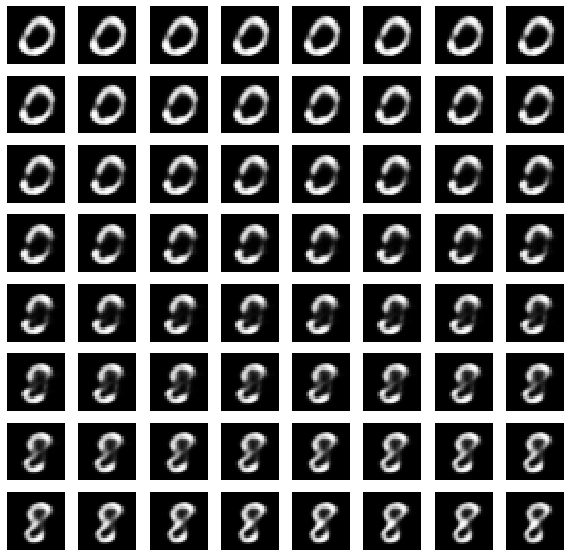

In [120]:
# Let's explore linearly
expl = linear_exploration(avg_zeros_latent, avg_eights_latent, 64)
expl_as_images = dec_model.predict(expl)
plots.plot_images(expl_as_images[0:64].reshape(-1, 28, 28), dim_x=28, dim_y=28, fig_size=(10,10))

## [Task 3] (25 points) Extracting Features. Let's use the autoencoder for feature extraction. Then we will train a classifier on the basis of the extracted features.

### [Task 3a] (5 points) Extract feature representations for train_x, val_x, and test_x using the AE. Name the new feature matrices 'fext_train_x', 'fext_val_x' , and 'fext_test_x'

In [121]:
###* put your code here (~3 lines) *###
fext_train_x=enc_model.predict(train_x)
fext_test_x=enc_model.predict(test_x)
fext_val_x=enc_model.predict(val_x)



In [122]:
assert fext_train_x.shape[1] == latent_width and fext_train_x.shape[1] == fext_val_x.shape[1] and fext_train_x.shape[1] == fext_test_x.shape[1]

### [Task 3b] (20 points) Fill in the implementation of create_compile_classifier(). You can use an architecture of your choice (it can be simple), but the classifier must use the features (latent space representation) extracted by the AE. Your classifier should get 95%+ accuracy.

In [130]:
def create_compile_classifier(latent_width=latent_width, num_outputs=10, verbose=True):
    name = 'Model-ExtFeatures'
    
    ###* put your code here (~10 lines) *###
    input_l=Input(shape=latent_width,)
    fc1 = Dense(128, activation='relu')(input_l)
    fc2 = Dense(64, activation='relu')(fc1)
    fc3 = Dense(32, activation='relu')(fc2)
    output_l = Dense(num_outputs, activation = 'softmax')(fc3) 
    model = keras.Model(inputs=[input_l], outputs=[output_l],name='Encoder')
    opt = keras.optimizers.Adam()
    
    if verbose:
        model.summary()
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return name, model

In [131]:
# Train the classifier
_, classifier = create_compile_classifier(verbose=True)
    
max_epochs = 25
batch_size = 64

hist = classifier.fit(fext_train_x, train_y, epochs=max_epochs, batch_size=batch_size, validation_data=(fext_val_x, val_y))

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 48)]              0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               6272      
_________________________________________________________________
dense_19 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_20 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_21 (Dense)             (None, 10)                330       
Total params: 16,938
Trainable params: 16,938
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
938/938 [==============================] - 1s 1ms/step - loss: 1.1119 - accuracy: 0.6561 - val_loss: 0.3500 - 

In [132]:
test_loss, test_acc = classifier.evaluate(fext_test_x, test_y, verbose=0)

print('[{}] Test loss: {:.5f}, test accuracy: {:.3f}%'.format(name, test_loss, 100*test_acc))

[AE-simple] Test loss: 0.08572, test accuracy: 97.540%


## [Task 4] (25 points) Sampling new data points. In this task, you will attempt to produce *new* images of digits using the auto-encoder and classifier.

### [Task 4a] (10 points) Briefly describe what you know about the range and distribution of the latent space of the AE (ae_model) trained in Task 1? (Hint: think about the architecture. What do you know about the latent space?)

In [ ]:
###* put your answer here *###
# Since the ae model trained is not from a particular distribution, I think there isn't a particular distribution. But 
#  there might be a range of values.
#

### [Task 4b] (5 points) Given your answer to the previous question, provide a plausible distribution that you could easily sample from to obtain valid latent space points. For this you cannot use the data!

In [ ]:
###* put your answer here *###
# One of the plausible distribution is normal distribution that could be used to gain valid space points.
# 
#

### [Task 4c] (5 points) Complete the implementation of sample_new_digits() by sampling points from the distribution you mentioned in 4b. You should *not* use any data (train_x/y, val_x/y, test_x/y, etc.).

In [133]:
def sample_new_digits(dec_model, count, latent_width=latent_width):
    ### sample 'count' latent space points and store the resulting array in 'sampled_latent_space_points'
    ###* put your code here (~1-2 lines) *###
    sampled_latent_space_points = tf.random.normal((count, latent_width), mean=0.0, stddev=1.0)


    return dec_model.predict(sampled_latent_space_points) # decode the sampled points

### Let's produce new images and see what they look like.

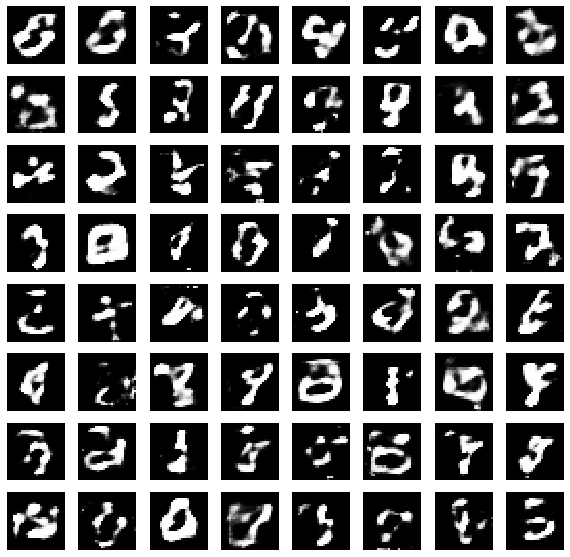

In [134]:
# generate 64 new images
sample_images = sample_new_digits(dec_model, 64, latent_width=latent_width)

# plot the produced images
plots.plot_images(sample_images[0:64].reshape(-1, 28, 28), dim_x=28, dim_y=28, fig_size=(10,10))

### [Task 4d] (5 points) Do the new images look like digits? If not, explain why not.

In [ ]:
###* put your answer here *###
# No, the images does not look like digits. This is because the auto encoder isn't trained to reconstuct data from an 
# underlying distribution.

## [CIS6930 Additional Task -- Task 5] (25 points): Variational AutoEncoders

### For this task, you will use the provided VAE implementation in nets.py. The goal is to train the model and use it to generate new samples.

### [Task 5a] (10 points) Fill in the implementation below to create the VAE and model and train it.

In [142]:
latent_width = 48

### Create a VAE using nets.create_simple_vae() then train it for at least 25 epochs.
### Make sure the latent width of the VAE is set to 48
###* put your code here (~2-4 lines) *###
vae,_,dec=nets.create_simple_vae(latent_width=48)
max_epochs = 30
batch_size = 256
hist=vae.fit(train_x, train_x, epochs=max_epochs, batch_size=batch_size, validation_data=(val_x, val_x))


Epoch 1/30
235/235 [==============================] - 4s 16ms/step - loss: 0.3130 - binary_crossentropy: 0.3068 - mse: 0.0821 - val_loss: 0.2204 - val_binary_crossentropy: 0.2042 - val_mse: 0.0481
Epoch 2/30
235/235 [==============================] - 4s 18ms/step - loss: 0.2110 - binary_crossentropy: 0.1921 - mse: 0.0438 - val_loss: 0.1869 - val_binary_crossentropy: 0.1635 - val_mse: 0.0340
Epoch 3/30
235/235 [==============================] - 4s 17ms/step - loss: 0.1836 - binary_crossentropy: 0.1596 - mse: 0.0326 - val_loss: 0.1734 - val_binary_crossentropy: 0.1480 - val_mse: 0.0287
Epoch 4/30
235/235 [==============================] - 4s 18ms/step - loss: 0.1716 - binary_crossentropy: 0.1460 - mse: 0.0280 - val_loss: 0.1679 - val_binary_crossentropy: 0.1421 - val_mse: 0.0266
Epoch 5/30
235/235 [==============================] - 5s 20ms/step - loss: 0.1659 - binary_crossentropy: 0.1389 - mse: 0.0256 - val_loss: 0.1636 - val_binary_crossentropy: 0.1361 - val_mse: 0.0247_
Epoch 6/30
235

### [Task 5b] (5 points) Similar to Task 2a, use plot_images() to plot the first 64 data points in the val_x. Then reconstruct val_x using the VAE and plot the first 64 data points of the reconstructed data. 

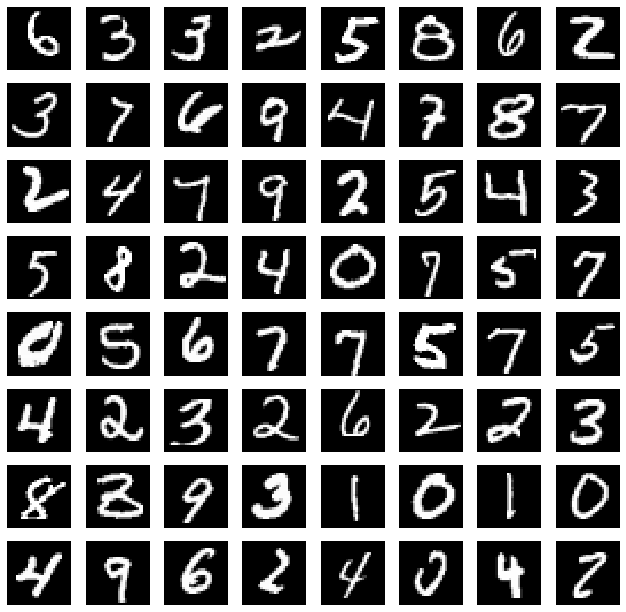

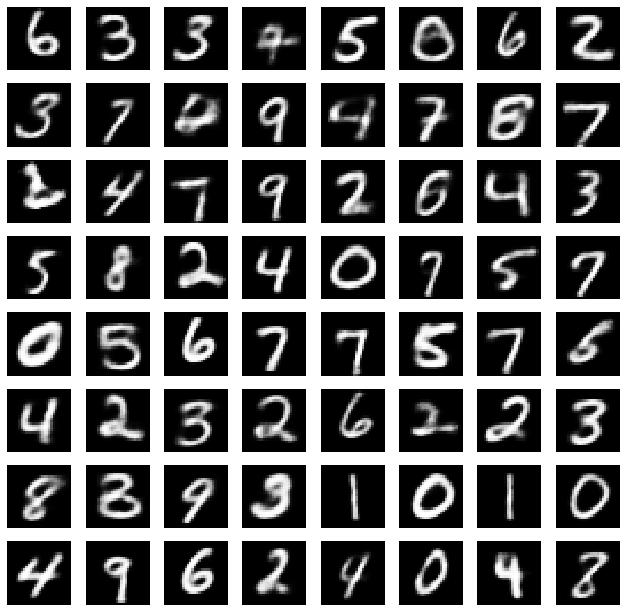

In [143]:
# Plot the first 64 data points of val_x using plots.plot_images()
###* put your code here (~1 line) *###
plots.plot_images(val_x[0:64].reshape(-1, 28, 28), dim_x=28, dim_y=28, fig_size=(11,11))


# Run the first 64 data points in val_x through the VAE to obtain reconstructed_val_x
###* put your code here (~1 line) *###
reconstructed_val_x=vae.predict(val_x[0:64])

# Plot the reconstructed data
###* put your code here (~1 line) *###
plots.plot_images(reconstructed_val_x[0:64].reshape(-1, 28, 28), dim_x=28, dim_y=28, fig_size=(11,11))


### [Task 5c] (5 points) What is the latent-space distribution for the VAE?

In [144]:
###* put your answer here *###
# It is a normal distibution.
# 
#

### [Task 5d] (5 points) Complete the implementation below by sampling points from the distribution you mentioned in 5c. You should *not* use any data (train_x/y, val_x/y, test_x/y, etc.).

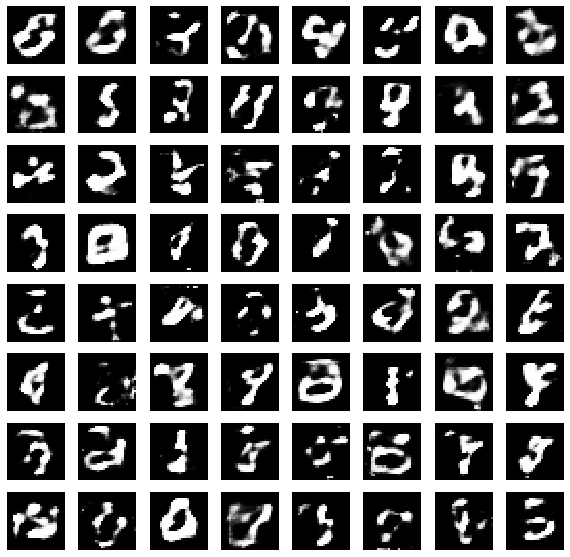

In [145]:
### You should sample 100 latent-space points (from the distribution you describe in 5c) and
### then you should decode these points into images (call the resulting array 'sample_images').
###* put your code here (~1-2 lines) *###
sampled_latent_space_points = tf.random.normal((64, latent_width), mean=0.0, stddev=1.0)
sample_images=dec.predict(sampled_latent_space_points)

plots.plot_images(sample_images[0:64].reshape(-1, 28, 28), dim_x=28, dim_y=28, fig_size=(10,10))